<a href="https://colab.research.google.com/github/morcellinus/2021_Summer_PSAT_Seminar/blob/main/Preprocessing_for_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 디렉토리 설정, 라이브러리 불러오기, 데이터 불러오기 

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/Shareddrives/🍕PSAT_Summer_Seminar_Team1🍕/Data/train.csv')
test_df = pd.read_csv('/content/drive/Shareddrives/🍕PSAT_Summer_Seminar_Team1🍕/Data/test.csv')

### 2. EDA

#### 1) Target class 비율 확인 

In [ ]:
train_df['target'].value_counts()

0    25191
1     2809
Name: target, dtype: int64

#### 1-1) Target class 비율 시각화 

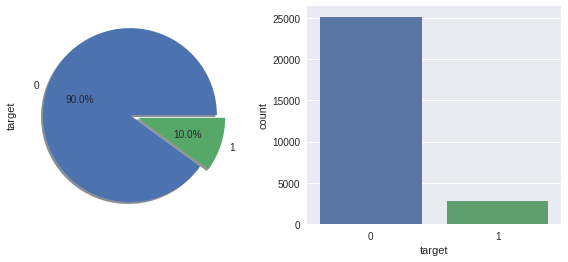

In [ ]:
f, ax = plt.subplots(1,2,figsize=(10,4))
train_df['target'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)
sns.countplot('target', data=train_df, ax=ax[1])
plt.show()



#### 2) column별 NA값 확인 

In [ ]:
# 각 데이터중 NA가 얼마나 들어있는지/NA가 아닌것(이하 notNA)은 얼마나 들어있는지 비율 체크

na_value = train_df.isna().sum().sort_values(ascending = False)
na_percent = round(train_df.isna().sum().sort_values(ascending = False)/len(train_df)*100, 2)
notna_percent = round(train_df.notna().sum()/len(train_df)*100, 2)


In [ ]:
# NA비율과 notMA비율을 모든 변수에서의 평균을 구함

entire_na_percent = np.mean(na_percent)
entire_notna_percent = np.mean(notna_percent)

In [ ]:
# NA/notNA의 퍼센트를 데이터프레임으로 만듦

na_notna_df = pd.DataFrame([entire_notna_percent, entire_na_percent],
                               index = pd.Index(["notNA", "NA"]))
na_notna_df.columns = ['percent']
na_notna_df

,percent
notNA,100.0
NA,0.0


#### 2-1) NA와 notNA 시각화

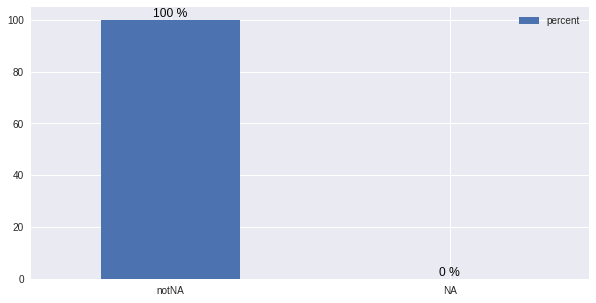

In [ ]:
# NA비율을 barplot으로 시각화 

na_notna_df.plot.bar(figsize=(10, 5))
plt.xticks(rotation = 0)


plt.text(0.0, 100, s = "%d %%"%(entire_notna_percent) ,
         color = "black",
         horizontalalignment = "center",
         verticalalignment = "bottom",
         fontsize = 12)
plt.text(1.0, 0, s = "%d %%"%(entire_na_percent) ,
         color = "black",
         horizontalalignment = "center",
         verticalalignment = "bottom",
         fontsize = 12)


plt.show()

#### 3) 중복데이터 시각화

In [ ]:
# 중복데이터인 데이터(이하 dup)와 중복데이터가 아닌 데이터(이하 notdup)는 각각 얼마나 들어있는지 비율 계산

duplicate_value = sum(train_df.duplicated())
dup_percent = round(train_df.duplicated().sum()/len(train_df)*100, 2)
notdup_percent = round((len(train_df) -sum(train_df.duplicated()))/len(train_df)*100, 2)

In [ ]:
# dup과 notdup의 데이터프레임 만듦

dup_notdup_df = pd.DataFrame([notdup_percent, dup_percent],
                               index = pd.Index(["Duplicate X", "Duplicate O"]))
dup_notdup_df.columns = ['percent']
dup_notdup_df

,percent
Duplicate X,100.0
Duplicate O,0.0


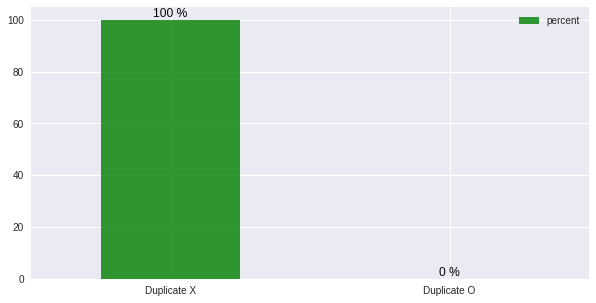

In [ ]:
# 중복데이터 비율을 barplot으로 시각화 

dup_notdup_df.plot.bar(figsize=(10, 5),
                       color = "green",
                       alpha = 0.8)
plt.xticks(rotation = 0)


plt.text(0.0, 100, s = "%d %%"%(notdup_percent) ,
         color = "black",
         horizontalalignment = "center",
         verticalalignment = "bottom",
         fontsize = 12)
plt.text(1.0, 0, s = "%d %%"%(dup_percent) ,
         color = "black",
         horizontalalignment = "center",
         verticalalignment = "bottom",
         fontsize = 12)

plt.show()

#### 4) column별 train data와 test data의 변수별 평균값 분포 시각화 

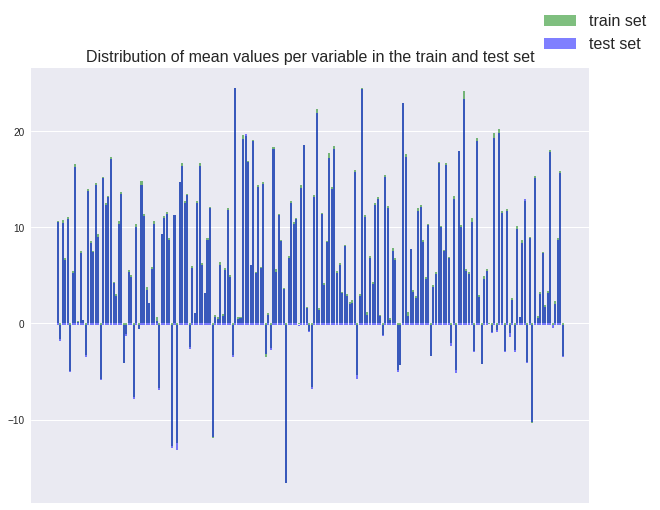

In [ ]:
train_features_name = train_df.drop(['target'],axis=1).columns
train_features_mean = train_df[train_features_name].mean(axis = 0)
test_features_name = test_df.columns
test_features_mean = test_df[test_features_name].mean(axis = 0)

fig,axes=plt.subplots()
fig.set_size_inches(10, 8)
axes.bar(train_features_name, train_features_mean, color = 'green',
         alpha = 0.5, label = "train set")

twin_axes = axes.twinx()
twin_axes.bar(test_features_name, test_features_mean, color = "blue",
         alpha = 0.5, label = "test set")

fig.legend(fontsize = 16)

plt.yticks(ticks= [])
plt.xticks(ticks= [])

plt.title("Distribution of mean values per variable in the train and test set",
          fontsize = 16)

plt.show()


#### 5) row별 train data와 test data의 변수별 표준편차값 분포 시각화 

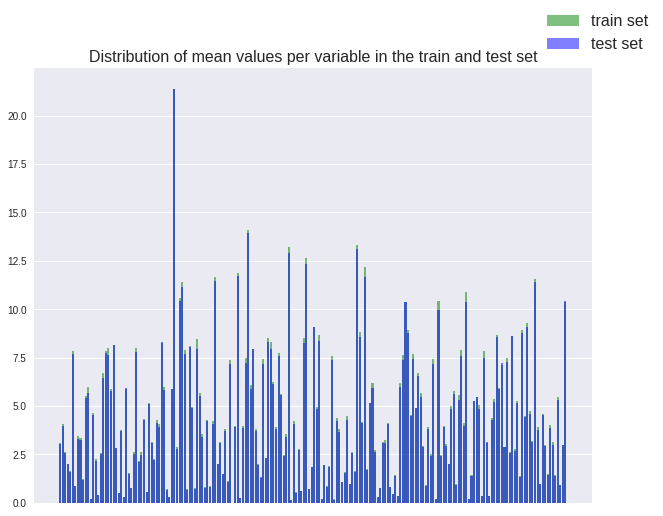

In [ ]:
train_features_name = train_df.drop(['target'],axis=1).columns
train_features_sd = train_df[train_features_name].std(axis = 0)
test_features_name = test_df.columns
test_features_sd = test_df[test_features_name].std(axis = 0)

fig,axes=plt.subplots()
fig.set_size_inches(10, 8)
axes.bar(train_features_name, train_features_sd, color = 'green',
         alpha = 0.5, label = "train set")

twin_axes = axes.twinx()
twin_axes.bar(test_features_name, test_features_sd, color = "blue",
         alpha = 0.5, label = "test set")

fig.legend(fontsize = 16)

plt.yticks(ticks= [])
plt.xticks(ticks= [])

plt.title("Distribution of mean values per variable in the train and test set",
          fontsize = 16)

plt.show()


#### 8) 변수 간 상관관계 시각화 

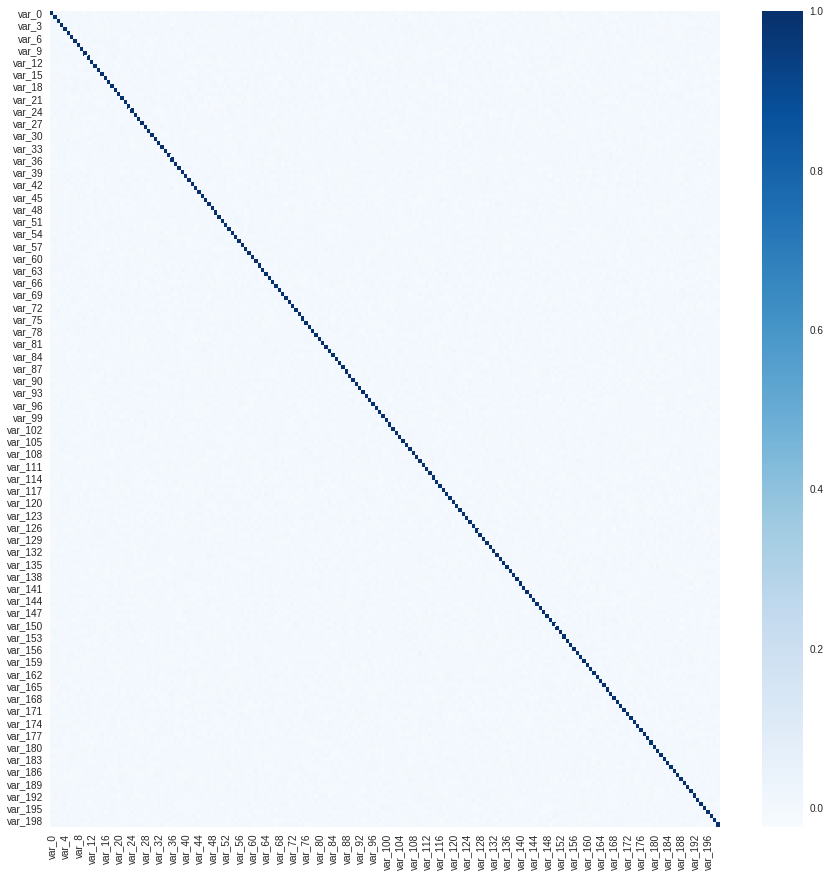

In [ ]:
cor = train_df.drop('target',axis = 1).corr()

plt.figure(figsize = (15, 15))
sns.heatmap(cor, annot = False,
            cmap = "Blues")

#### 9) PCA 적용시 데이터 분포 시각화 

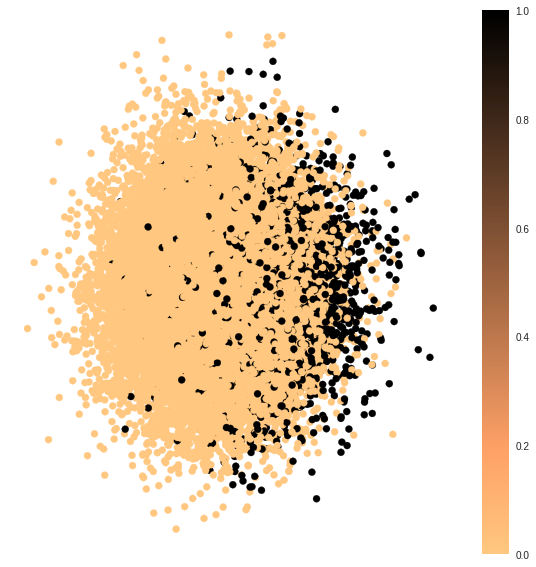

In [ ]:
x = train_df.drop(['target'], axis=1,)
y = train_df['target']

# PCA를 위한 스케일링

scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

# PC = 2로 PCA

pca = PCA(n_components=2)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)
test_scaler = StandardScaler()
trans_test_scaler = test_scaler.fit_transform(test_df)
trans_test_scaler_df = pd.DataFrame(trans_test_scaler, columns=test_df.columns)

# 시각화

x_scaler_pca_df['target'] = y
plt.figure(figsize = (10, 10))
plt.scatter(x_scaler_pca_df.loc[:, 0], x_scaler_pca_df.loc[:, 1], c=y,  cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

# PCA not recommended